# Flowers Classification using Inception_ResnetV2 Model

### Download Flowers dataset

In [0]:
#You can download the data manually as well instead of using 'wget'
!wget http://download.tensorflow.org/example_images/flower_photos.tgz --quiet

In [0]:
#Read the dataset
import tarfile
dataset = tarfile.open('flower_photos.tgz')

In [0]:
#We will build a pandas dataset
import pandas as pd
df = pd.DataFrame(columns=['class','image_file'])

In [0]:
#Run through tarfile members 
for name in dataset.getnames():
    tar_mem = dataset.getmember(name)
    #Check if it is a file
    if(tar_mem.isfile() and name.endswith('.jpg')):
        #Build directory and class info
        im_dir = name[0:name.rfind('/')]
        im_class = im_dir[im_dir.rfind('/')+1:]
        #Add record to the dataframe
        df.loc[df.shape[0]] = [im_class, name]

In [0]:
#extract data
dataset.extractall(path='')

In [6]:
!ls -l flower_photos

total 616
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  53248 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  45056 Feb 10  2016 tulips


Create Training & Test Dataset

In [0]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [0]:
train_df.to_csv('flower_photos/train.csv',index=False)
test_df.to_csv('flower_photos/test.csv', index=False)

### Read training and test data

In [0]:
#Read training and test Dataframe
train_df = pd.read_csv('flower_photos/train.csv')
test_df = pd.read_csv('flower_photos/test.csv')

In [10]:
#Check contents
train_df.sample(n=5)

,class,image_file
2090,sunflowers,flower_photos/sunflowers/6145005439_ef6e07f9c6...
2404,roses,flower_photos/roses/15190665092_5c1c37a066_m.jpg
1931,daisy,flower_photos/daisy/5769217520_c90efc3c93_m.jpg
22,daisy,flower_photos/daisy/433837534_1dbf798b73.jpg
1027,dandelion,flower_photos/dandelion/463736819_f779800165.jpg


In [11]:
#Get class names
class_names = train_df['class'].unique().tolist()
print('Flower classes: ', class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


### Build Batch generator (using ImageDataGenerator)

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
#Define some parameters
img_size = 224
img_depth = 3  

Function to normalize image according to Model being used

In [0]:
def normalize_data(img):
    #Normalize for Inception Resnet V2
    return tf.keras.applications.inception_resnet_v2.preprocess_input(img)

Defime ImageDataGenerator for both Training and Test Separately

In [0]:
#Define Training Data Generator with augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                preprocessing_function=normalize_data) #Normalize the data accordingly

#Define Test Data Generator with NO augmentations
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=normalize_data) #Normalize the data accordingly

Create Data Generators objects for Training and Test

In [16]:
#Training (from dataframe)
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='image_file', #File path for image
                                                    y_col='class',           #Class for the image
                                                    target_size=(img_size, img_size), #Image resize dimensions
                                                    batch_size=64)

Found 2936 validated image filenames belonging to 5 classes.


In [17]:
#Test (from dataframe)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='image_file', #File path for image
                                                  y_col='class',           #Class for the image
                                                  target_size=(img_size, img_size), #Image resize dimensions
                                                  batch_size=64)

Found 734 validated image filenames belonging to 5 classes.


ImageDataGenerator has lot of useful features. Learn more about ImageDataGenerator at https://keras.io/preprocessing/image/

In [0]:
#Function to compare the metrics - loss and accuracy for training validation stes over a no of epochs
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metrics(history, ax, fontsize, col1, col2, x_label, y_label, title):
    ax.plot((history.history[col1]))
    ax.plot((history.history[col2]))
    #ax.locator_params(nbins=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(['Training-data', 'Test-data'])
    ax.set_title(title)

### Load pre-trained model Inception_ResnetV2 model

In [18]:
tf.keras.backend.clear_session()
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=(224,224, img_depth),
                                       weights='imagenet')

219062272/219055592 [==============================] - 2s 0us/step


In [19]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [20]:
model.output

<tf.Tensor 'conv_7b_ac/Identity:0' shape=(None, 5, 5, 1536) dtype=float32>

Freeze the layers in Pre-trained model

In [21]:
len(model.layers)

780

In [0]:
#Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = False

In [23]:
#Check if layers frozen
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

### Add FC layer for new classes

In [0]:
#get Output layer of Pre0trained model
x = model.output

#Global average pool to reduce number of features and Flatten the output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [35]:
#Output shape of Global Average Pooling
x

<tf.Tensor 'global_average_pooling2d_1/Identity:0' shape=(None, 1536) dtype=float32>

In [0]:
#Add output layer
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

### Building final model for Classification

In [0]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [0]:
#Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
#How does our overall model looks
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

### Train the model

In [0]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('flowers_resnet.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_acc', 
                                                    mode='max', 
                                                    verbose=1)

In [41]:
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=5,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 1/5
45/45 [==============================] - 62s 1s/step - loss: 0.9118 - accuracy: 0.6448 - val_loss: 0.6211 - val_accuracy: 0.7514
Epoch 2/5
45/45 [==============================] - 58s 1s/step - loss: 0.5717 - accuracy: 0.7977 - val_loss: 0.5389 - val_accuracy: 0.7841
Epoch 3/5
45/45 [==============================] - 58s 1s/step - loss: 0.4765 - accuracy: 0.8283 - val_loss: 0.4536 - val_accuracy: 0.8224
Epoch 4/5
45/45 [==============================] - 59s 1s/step - loss: 0.4370 - accuracy: 0.8454 - val_loss: 0.4556 - val_accuracy: 0.8182
Epoch 5/5
45/45 [==============================] - 58s 1s/step - loss: 0.3967 - accuracy: 0.8600 - val_loss: 0.4327 - val_accuracy: 0.8338


In [0]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

In [42]:
#Lets train for 5 more steps
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=10,
                          initial_epoch=5,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 6/10
45/45 [==============================] - 58s 1s/step - loss: 0.3789 - accuracy: 0.8673 - val_loss: 0.4198 - val_accuracy: 0.8480
Epoch 7/10
45/45 [==============================] - 58s 1s/step - loss: 0.3599 - accuracy: 0.8740 - val_loss: 0.4071 - val_accuracy: 0.8494
Epoch 8/10
45/45 [==============================] - 59s 1s/step - loss: 0.3420 - accuracy: 0.8830 - val_loss: 0.4232 - val_accuracy: 0.8267
Epoch 9/10
45/45 [==============================] - 59s 1s/step - loss: 0.3443 - accuracy: 0.8774 - val_loss: 0.3997 - val_accuracy: 0.8466
Epoch 10/10
45/45 [==============================] - 59s 1s/step - loss: 0.3370 - accuracy: 0.8767 - val_loss: 0.4322 - val_accuracy: 0.8295


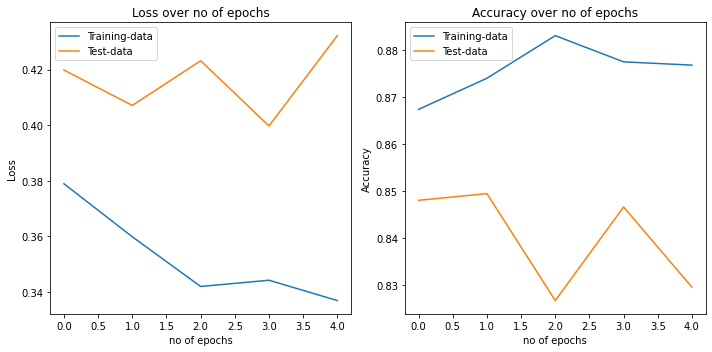

In [43]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

### Unfreeze some of Trained Layers in Inception ResNetV2

At this point, our model is overfit. How do we improve our model when using Transfer Learning. Here are some approaches to try:

1. Unfreeze lesser number of layers (fewer parameters to train)
2. Train unfrozen layer with smaller learning rate (avoiding big changes to weights)
3. Use Dropout before output layer

In [47]:
print("Number of Layers:",len(model.layers))

Number of Layers: 780


Let's unfreeze 10% at the end (which have high end features more specific to ImageNet)

In [0]:
#Unfreezing all layers after layer# 158
for layer in model.layers[703:]:
    layer.trainable = True    

In [49]:
#We will need to recompile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [50]:
#Lets train for 10 steps
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=20,
                          initial_epoch=10,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 11/20
45/45 [==============================] - 100s 2s/step - loss: 0.4333 - accuracy: 0.8597 - val_loss: 99.9821 - val_accuracy: 0.4176
Epoch 12/20
45/45 [==============================] - 95s 2s/step - loss: 0.2749 - accuracy: 0.9095 - val_loss: 42.2959 - val_accuracy: 0.6207
Epoch 13/20
45/45 [==============================] - 95s 2s/step - loss: 0.1916 - accuracy: 0.9279 - val_loss: 1.9856 - val_accuracy: 0.8537
Epoch 14/20
45/45 [==============================] - 95s 2s/step - loss: 0.1440 - accuracy: 0.9540 - val_loss: 0.4552 - val_accuracy: 0.8679
Epoch 15/20
45/45 [==============================] - 95s 2s/step - loss: 0.1293 - accuracy: 0.9576 - val_loss: 3.1324 - val_accuracy: 0.8040
Epoch 16/20
45/45 [==============================] - 95s 2s/step - loss: 0.1665 - accuracy: 0.9499 - val_loss: 5.8826 - val_accuracy: 0.6676
Epoch 17/20
45/45 [==============================] - 95s 2s/step - loss: 0.1113 - accuracy: 0.9627 - val_loss: 1.0759 - val_accuracy: 0.7656
Epoch 18/2

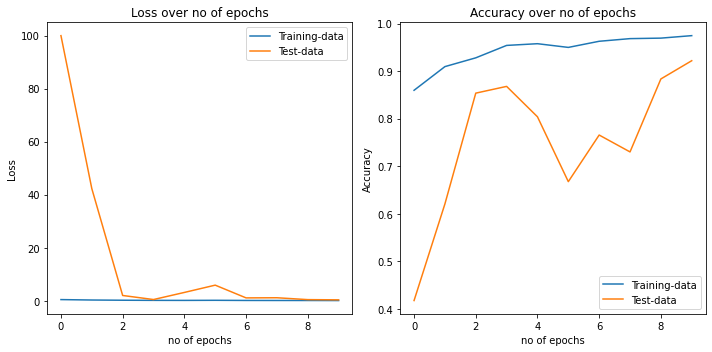

In [51]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

In [52]:
#Lets train for 10 more steps
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=30,
                          initial_epoch=20,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 21/30
45/45 [==============================] - 95s 2s/step - loss: 0.0550 - accuracy: 0.9805 - val_loss: 0.5793 - val_accuracy: 0.8665
Epoch 22/30
45/45 [==============================] - 95s 2s/step - loss: 0.0676 - accuracy: 0.9798 - val_loss: 0.3734 - val_accuracy: 0.9091
Epoch 23/30
45/45 [==============================] - 95s 2s/step - loss: 0.0564 - accuracy: 0.9798 - val_loss: 0.3012 - val_accuracy: 0.9119
Epoch 24/30
45/45 [==============================] - 95s 2s/step - loss: 0.0432 - accuracy: 0.9857 - val_loss: 0.3892 - val_accuracy: 0.9119
Epoch 25/30
45/45 [==============================] - 95s 2s/step - loss: 0.0457 - accuracy: 0.9840 - val_loss: 0.4513 - val_accuracy: 0.8906
Epoch 26/30
45/45 [==============================] - 95s 2s/step - loss: 0.0751 - accuracy: 0.9746 - val_loss: 0.4903 - val_accuracy: 0.8906
Epoch 27/30
45/45 [==============================] - 95s 2s/step - loss: 0.0647 - accuracy: 0.9788 - val_loss: 0.6169 - val_accuracy: 0.8651
Epoch 28/30
4

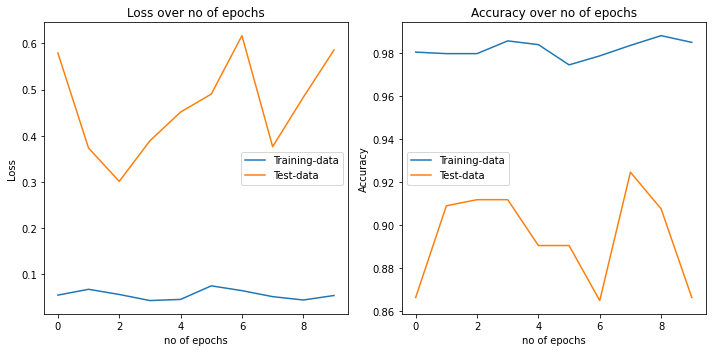

In [53]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

### Training accuracy is 98.8% and Validation accuracy is 92.4%